# Analiza tekmovnj na Codeforces

## Priprava
Najprej moramo naložiti pandas in si pripraviti podatke, ki jih bomo potrebovali za analizo.

In [1]:
import pandas as pd
import os.path

pd.options.display.max_rows = 20

%matplotlib inline

# nalozimo razpredelnice
users_path = os.path.join("obdelani_podatki", "users.csv")
users = pd.read_csv(users_path, index_col='id')

tasks_path = os.path.join("obdelani_podatki", "tasks.csv")
tasks = pd.read_csv(tasks_path, index_col='id')

submissions_path = os.path.join("obdelani_podatki", "submissions.csv")
submissions = pd.read_csv(submissions_path, index_col='id')

contestants_path = os.path.join("obdelani_podatki", "contestants.csv")
contestants = pd.read_csv(contestants_path, index_col='id')

In [2]:
users

,name,rank,country
id,,,
1,HIR180,Legendary Grandmaster,Japan
2,9623,International Master,Antarctica
3,stasio6,International Master,Poland
4,sigma425,International Grandmaster,Japan
5,jiangly,Legendary Grandmaster,China
...,...,...,...
13876,DoIudu123,Newbie,Taiwan
13877,logicccc,Unrated,NaN
13878,EasyMode,Expert,Brazil


In [3]:
tasks

,contest,number
id,,
1,1,1
2,1,2
3,1,3
4,1,4
5,1,5
...,...,...
1113,189,2
1114,189,3
1115,189,4


In [4]:
submissions

,contestant,task,proglang,time
id,,,,
1,1,1,c++,1.0
2,1,2,c++,6.0
3,1,3,c++,65.0
4,1,4,c++,26.0
5,1,5,c++,26.0
...,...,...,...,...
223396,35200,419,c++,33.0
223397,35200,420,c++,52.0
223398,35200,421,c++,106.0


In [5]:
contestants

,user,contest,place
id,,,
1,1,1,1
2,1,3,99
3,1,24,41
4,1,29,37
5,1,31,29
...,...,...,...
35196,13876,200,163
35197,13877,200,166
35198,13878,200,174


Spodobi se najprej na kratko razložiti, kako delujejo tekmovanja na codeforces in kaj pomenijo podatki v posameznih stolpcih tabel.
Na spletni trani codeforces so pogosto tekmovanja, na katerih tekmujejo programerji iz celega sveta. Na vsakem tekmovanju je nekaj nalog (tasks), ki jih morajo tekmovalci (contestants) rešiti. To naredijo tako, da napišejo ustrezno kodo, ki jo zahteva naloga, in to kodo oddajo. Taki oddajo kode rečemo tudi submission. 

**Users**  
V tej tabeli se nahajajo podatki tekmovalcev, ki so tekmovali na zadnjih 100 tekmovanjih. Ker je vsak od njih lahko sodeloval na več tekmovanjih, imamo za vsakega uporabnika in vsako tekmovanje, na katerem je bil, še zapis v tabeli *contestants*.    

Za vsakega imamo podano:
* uporabniško ime
* rank (glede na codeforces rating)
* državo (ni zagotovila, da so podatki o državi resnični)

**Tasks**  
Za vsako nalogo imamo shranjeno tekmovanje, na katerem se je pojavila, in zaporedno številko naloge na tem tekmovanju.

**Submissions**  
Za vsako oddajo imamo podane naslednje podatke:
* tekmovalec, ki je naredil oddajo
* naloga h kateri spada ta oddaja
* programski jezik
* čas od začetka tekmovanja

**Contestants**  
Ta tabela povezuje tekmovanja in tekmovalce/uporabnike.  
Vsak vnos v tej tabli ima:
* uporabnika, ki je sodeloval na tekmovanju
* tekmovanje
* uvrstitev na tekmovanju

Cilj naloge je ovreči ali potrditi naslednje **hipoteze**:
* Najboljši tekmovalci prvo nalogo rešijo v manj kot 10 minutah
* Več kot 80 % od vseh oddaj je v jeziku c++, manj kot 5 % pa v pythonu
* Tekmovalci, ki so bili na več tekmovanjih, so bolši kot tisti, ki so bili na manj tekmovanjih

Poleg tega bomo nekoliok bolj podrobno obravnavali tudi naslednja vprašanja:
* Iz katerih držav so najboljši programerji?
* Ali obstaja povezava med tem, kako hitro nek tekmovalec rešuje lahke naloge in tem, kako težke naloge je sposoben rešiti?
* Kako udeležba na tekmovanjih vpliva na uspeh na tekmovanjih?

## Od kod so najbolši programerji
V tem razdelku bomo ugotovili, iz katerih držav prihajajo najboljši tekmovalci na zadnih 200 tekmovanjih na codeforces.  
Najprej si poglejmo, koliko tekmovalcev je iz katere države.

In [6]:
users_by_country = users.groupby("country").size().sort_values().tail(15)
users_by_country

country
Kazakhstan        140
Belarus           140
Brazil            145
Taiwan            147
Poland            149
Ukraine           164
Iran              165
United States     257
Bangladesh        261
South Korea       288
Vietnam           299
Japan             497
Russia           1057
India            1692
China            1809
dtype: int64

<AxesSubplot:xlabel='country'>

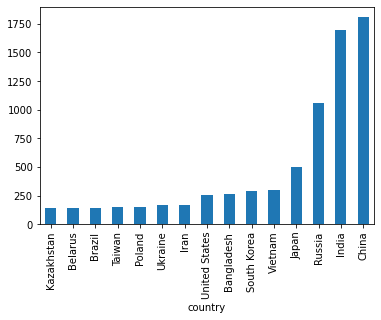

In [7]:
users_by_country.plot.bar()

Kot bi pričakovali, je iz držav z večjo populacijo več tekmovalcev.
Presenetljivo so ZDA šele na osmem mestu, čeprav so tretja največja država po populaciji in so dokaj razvita država (ni težav z dostopom do interneta ipd.).

Za vsakega uporabnika bomo določili njegov uspeh (score), ki bo mera tega, kako dobro se je odrezal na tekmovanjih, ki se jih je udeležil. Uspeh uporabnika bomo definirali kot `201 - povprečje uvrstitev po vseh tekmovanjih, ki se jih je udeležil`. Uspeh je tako med 0 in 200. Prikazan je v zadnjem stolpcu naslednje tabele.

In [8]:
avg_place = contestants.groupby("user", as_index=False)["place"].mean()
users = pd.merge(users, avg_place, left_on='id', right_on='user')
users["score"] = 201 - users.place
users = users.set_index("user")
users

,name,rank,country,place,score
user,,,,,
1,HIR180,Legendary Grandmaster,Japan,39.636364,161.363636
2,9623,International Master,Antarctica,42.000000,159.000000
3,stasio6,International Master,Poland,27.500000,173.500000
4,sigma425,International Grandmaster,Japan,39.000000,162.000000
5,jiangly,Legendary Grandmaster,China,27.571429,173.428571
...,...,...,...,...,...
13876,DoIudu123,Newbie,Taiwan,163.000000,38.000000
13877,logicccc,Unrated,NaN,166.000000,35.000000
13878,EasyMode,Expert,Brazil,174.000000,27.000000


Oglejmo si, kako zgledajo podatki, če se omejimo samo na najboljših 4000 (to je približno 10 % vseh uporabnikov, ki jih analiziramo) uporabnikov.

In [9]:
best_by_country = users.sort_values("score", ascending=False)[:4000].groupby("country").size().sort_values().tail(15)
best_by_country

country
Egypt             35
Brazil            35
Romania           35
Poland            36
Ukraine           38
Kazakhstan        41
Iran              43
Bangladesh        54
United States     61
South Korea       88
Vietnam           95
Japan            125
Russia           276
India            368
China            558
dtype: int64

<AxesSubplot:xlabel='country'>

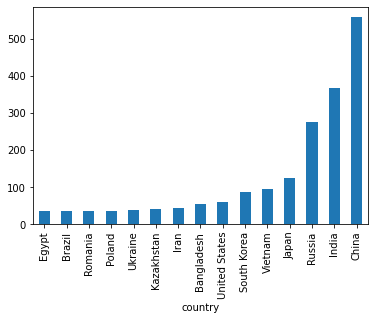

In [10]:
best_by_country.plot.bar()

Opazimo lahko, da je zelo majhen del tekmovalcev iz Indije med najboljšimi 4000 tekmovalci, če tekmovalce razvrstimo po njivem uspehu kot smo ga definirali zgoraj.  

Poskusimo definirati boljšo oceno za to, kako dobri so tekmovalci iz posamezne države. Do zdaj smo samo primerjali število tekmovalcev neke države s številom tekmovalcev iz te države, ki so med 4000 najbolšimi po številu točk. Ker že imamo uspeh (score) posameznih tekmovalcev, lahko definiramo uspeh države, kot vsoto točk vseh tekmovalcev iz te države. Od tu do konca razdelka bomo upoštevli le države z vsaj 30 tekmovalci.

,country,score,users
3,Antarctica,4015.152381,43
5,Armenia,3469.859524,34
11,Bangladesh,21961.459012,261
12,Belarus,12787.065006,140
19,Brazil,13039.571160,145
...,...,...,...
114,Taiwan,13763.088632,147
120,Turkey,5093.133333,44
122,Ukraine,15437.331100,164
124,United States,24203.613959,257


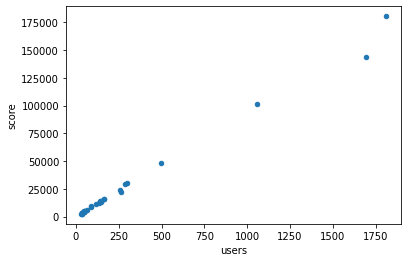

In [11]:
score_by_country = users.groupby("country", as_index=False)["score"].sum()
users_by_country = users.groupby("country", as_index=False).size().rename(columns={'size':'users'})
score_to_users = pd.merge(score_by_country, users_by_country, left_on='country', right_on='country')
score_to_users = score_to_users[score_to_users.users > 30]
score_to_users.plot.scatter("users", "score")
score_to_users

Opazimo, da število točk vsake države linearno narašča s številom tekmovalcev iz te države.
Kljub temu pa nekatere države odstopajo. Kot smo že prej ugotovili ima Indija v primerjavi z ostalimi državami majhen delež res dobrih programerjev. Na tem grafu Indijo predstavlja druga pika iz desne proti levi. Vidimo, da ima res majhno število točk glede na število tekmovalcev.  

Oglejmo si še države z največjim številom točk na tekmovalca.

<AxesSubplot:xlabel='country'>

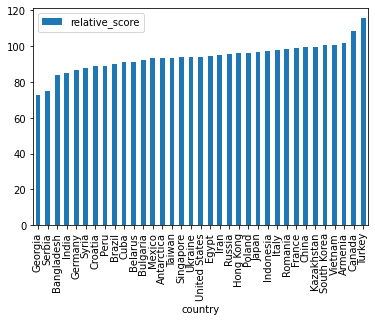

In [12]:
score_to_users["relative_score"] = score_to_users["score"] / score_to_users["users"]
score_to_users = score_to_users.sort_values("relative_score", ascending=True)
score_to_users.plot.bar(x="country", y="relative_score")

Iz grafa se vidi katere države so bolj uspešne in katere manj. Indija je med manj uspešnimi, kot so nam to kazali podatki že prej.

Najbolj uspešne države po našem kriteriju so Turčija, Kanada in Armenija. Med Evropskimi državam je najvišje Francija, sledita ji Romunija in Italija.

Zavedati se moramo, da ti podatki niso bili najbolj primerni za analizo tega, kako dobri v programerskih nalogah so ljudje iz različnih držav, saj vsebujejo le prvih 200 tekmovalcev na vsakem tekmovanju.

## Najbolj popularni programski jeziki
Smiselno se je vprašati, katerih jezikih najraje programerajo tekmovalci.  
Spodnja tabela in graf prikazujeta 5 največkrat uporabljenih programskih jezikov in število oddaj v vsakem od teh jezikov.

In [13]:
po_jezikih = submissions.groupby("proglang").size()
popularni_jeziki = po_jezikih.sort_values()[-5:]
popularni_jeziki

proglang
java        3362
python      3544
Q#          4516
Kotlin      4602
c++       146193
dtype: int64

<AxesSubplot:xlabel='proglang'>

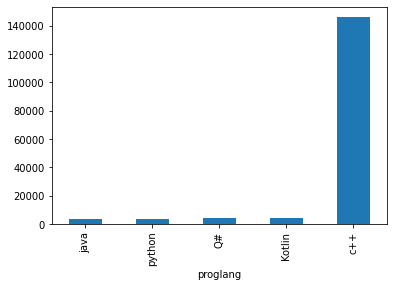

In [14]:
popularni_jeziki.plot.bar()

Vidimo, da je daleč najbolj popularen jezik med tekmovalnimi programerji c++, python pa je šele na petem mestu. To ni presenetljivo, saj je c++ precej hitrejši od pythona. Vseeno smo pričakovali, da bo v pythonu več oddaj, kot se je izkazalo da jih je, saj je ponavadi prvih nekaj nalog zelo enostavnih in se jih hitreje reši v pythonu, kjer je koda ponavadi krajša.

In [15]:
size = len(submissions[submissions.proglang.notnull()])
cpp_part = popularni_jeziki.loc["c++"] / size
python_part = popularni_jeziki.loc["python"] / size
print("Delež oddaj v c++:", round(cpp_part*100, 2), "%")
print("Delež oddaj v pythonu: ", round(python_part*100, 2), "%")

Delež oddaj v c++: 86.36 %
Delež oddaj v pythonu:  2.09 %


Torej je v pythonu precej manj kot 5 % vseh oddaj, v c++ pa je skoraj 87 % oddaj, torej več kot 80 %. 

## Hitrost reševanja

V tem razdelku si bomo ogledali, če obstaja kakšna korelacija med hitrostjo nekdo reševanja nalog in tem, kako težke naloge je nekdo sposoben rešiti.

Najprej tabeli uporabnikov dodajmo še en stolpec, ki bo pokazatelj tega, kako hitro kdo rešuje naloge. Za vsakega tekmovalca na vsakem tekmovanju bomo vzeli čas (v minutah), ki ga je porabil, da je uspešno rešil eno nalogo. Ponavadi vsi začnejo z reševanjem lahkih nalog (kar po vrsti) in pri teh nalogah tudi ni potrebno veliko znanja o algoritmih, treba je le hitro razumeti kaj naloga zahteva in implementirati rešitev. Zanima nas, če je to kako povezano tudi z zmožnostjo reševanja težkih nalog.

In [18]:
contestants["min_time"] = pd.merge(contestants, submissions, left_on="id", right_on="contestant").groupby("contestant").min()["time"]
contestants

,user,contest,place,min_time
id,,,,
1,1,1,1,1.0
2,1,3,99,9.0
3,1,24,41,38.0
4,1,29,37,4.0
5,1,31,29,5.0
...,...,...,...,...
35196,13876,200,163,4.0
35197,13877,200,166,14.0
35198,13878,200,174,6.0


Za vsako nalogo bomo ugotovili kakšen delež tekmovalcev jo je rešil. Težavnost naloge bo delež tekmovalcev (izmed prvih 200), ki niso rešili naloge.

In [19]:
everyone = submissions.groupby("task").size() 
solved = submissions[submissions.time.notnull()].groupby("task").size()
tasks["difficulty"] = 1 - solved / everyone
tasks

,contest,number,difficulty
id,,,
1,1,1,0.000
2,1,2,0.005
3,1,3,0.025
4,1,4,0.015
5,1,5,0.200
...,...,...,...
1113,189,2,0.005
1114,189,3,0.000
1115,189,4,0.020


Za vsakega tekmovalca na vsakem tekmovanju bomo ugotovili težavnost najtežje naloge, ki jo je rešil.  
Tekmovalec, ki porabi preveč časa, da reši prvo nalogo tako ali tako nima časa reševati težjih nalog.
Za takega tekmovalca težko rečemo kako težke naloge je sposoben reševati, zato se bomo omejili le na tekmovalce, ki prvo nalogo rešijo v manj kot 60 min (običajno tekmovanja trajajo okoli 2 uri).

,min_time,difficulty
contestant,,
1,1.0,0.950
2,9.0,0.980
3,38.0,0.955
4,4.0,0.995
5,5.0,0.990
...,...,...
35196,4.0,0.865
35197,14.0,0.865
35198,6.0,0.865


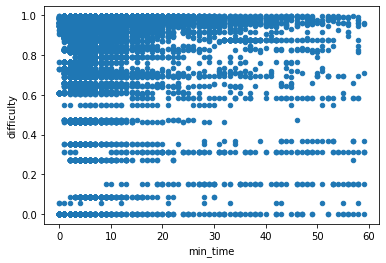

In [20]:
contestant_submission = pd.merge(contestants, submissions, left_on="id", right_on="contestant")
conestant_task = pd.merge(contestant_submission, tasks, left_on="task", right_on="id")
corelation = conestant_task.groupby("contestant").max()[["min_time", "difficulty"]]
corelation = corelation[corelation.min_time < 60]
corelation.plot.scatter("min_time", "difficulty")
corelation

Na levi so točke nakopičene pri vrhum, na desni strani pa so enakomerno razporejene po višini.
Vidimo, da so tekmovalci, ki hitreje rešijo prvo nalogo, ponavadi sposobni reševati težje naloge kot tisti, ki za prvo nalogo porabijo več časa.

Na hitro si oglejmo še, kolikšen del tekmovalcev, ki so se uvrstili med 200 najboljših, reši prvo nalogo v manj kot 10 minutah.

In [21]:
len(contestants[contestants.min_time <= 10]) / len(contestants)

0.7517045454545455

Ta delež je skoraj 74 %.

## Ali je res, da vaja dela mojstra?

Ogledali si bomo, kako se uvrstitve spreminjajo, ko je bil nek tekmovalec na več tekmovanjih. Zdi se, da bi si tekmovalci na prejšnih tekmovanjih, ki so se jih udeležili, pridobili kakšno izkušno in bi bili bolj uspešni na naslednjih.

Za vsakega uporabnika bomo ugotovili, na koliko tekmovanjih je bil. Temu številu bomo rekli izkušnje uporabnika in ga shranili v stolpec *exp* v tabeli uporabnikov.

In [22]:
users["exp"] = contestants.groupby("user")["contest"].count()
users

,name,rank,country,place,score,fav_language,exp
user,,,,,,,
1,HIR180,Legendary Grandmaster,Japan,39.636364,161.363636,c++,11
2,9623,International Master,Antarctica,42.000000,159.000000,c++,4
3,stasio6,International Master,Poland,27.500000,173.500000,c++,2
4,sigma425,International Grandmaster,Japan,39.000000,162.000000,c++,7
5,jiangly,Legendary Grandmaster,China,27.571429,173.428571,c++,63
...,...,...,...,...,...,...,...
13876,DoIudu123,Newbie,Taiwan,163.000000,38.000000,c++,1
13877,logicccc,Unrated,NaN,166.000000,35.000000,c++,1
13878,EasyMode,Expert,Brazil,174.000000,27.000000,c++,1


Izkušnje so med 1 in 200, saj imamo podatke le o 200 tekmovanjih (V resnici nihče ni bil na več kot 66 tekmovanjih). Uporabnike tako lahko združimo v skupine glede na to, koliko izkušenj imajo, nato pa za vsako skupino izračunamo povprečen uspeh (score).  
Spodnja tabela in diagram prikazujeta, kako je uspeh odvisen od izkušenj.

,exp,score
0,1,94.636279
1,2,98.447879
2,3,97.588235
3,4,96.094901
4,5,94.204706
...,...,...
46,51,135.549020
47,52,136.653846
48,55,136.727273
49,62,141.258065


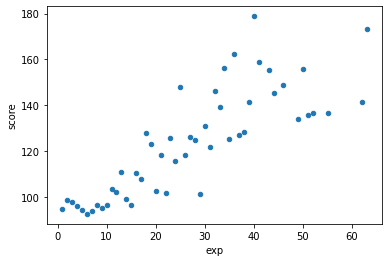

In [23]:
score_by_exp = users.groupby("exp", as_index=False)[["exp", "score"]].mean()
score_by_exp.plot.scatter("exp", "score")
score_by_exp

Vidimo, da uspeh narašča z izkušnjami (zgleda linearno). Torej je udeležba na tekmovanjih učinkovit način učenja.

Seveda obstaja tudi na codeforces sistem zbiranja točk, ki deluje na osnovi uvrstitev na starih tekmovanjih. Uporabniki z višjim številom točk so višjega ranga. Zanimivo bi bilo videti, kako se naš sistem primerja s tem.

,rank,score
6,Master,91.901130
1,Expert,92.034284
9,Specialist,93.834642
4,International Master,95.518757
8,Pupil,96.797787
0,Candidate Master,97.970953
2,Grandmaster,106.817379
7,Newbie,108.121115
3,International Grandmaster,130.329868
5,Legendary Grandmaster,165.593408


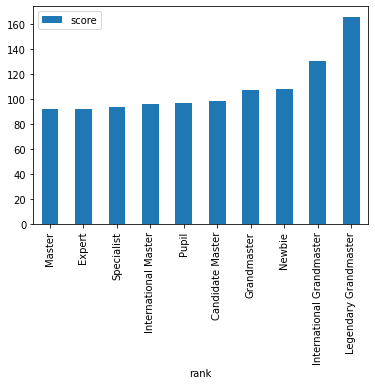

In [24]:
only_rated = users[users["rank"] != "Unrated"]
score_by_rank = only_rated[["rank", "score"]].groupby("rank", as_index=False).mean().sort_values("score", ascending=True)
score_by_rank.plot.bar(x="rank", y="score")
score_by_rank

Vidimo, da je rang *Newbie* precej visoko. Morda si nekateri ustvarijo nove račune in tekmujejo z njimi, tako so potem nizki rangi zelo uspešni. Tudi rank *Pupil* je nekoliko visoko, *Master* pa je nekoliko nizko. Razen teh nekaj anomalij pa se oba sistema točkovanj dokaj ujemata.

## Zakljiček

Ugotovili smo, da so dobri programerji enakomerno razporejeni po svetu. Seveda jih je več v državah, ki imajo tudi večjo populacijo.  
Velika večina tekmovalcev najraje programira v programskem jeziku c++, zelo malo pa v pythonu.  
Vaja in udeležba na tekmovanjih sta zelo hiter način napredovanja in učenja programiranja. To velja tudi za tiste, ki so že zelo dobri. V podatkih so bili zajeti le najboljši tekmovalci, pa je vseeno bila vidna močna zveza med številom udeleženih tekmovanj in rezultatom.  
Obstaja zveza med tem kako hitro tekmovalec rešuje naloge in kako težke naloge lahko reši. To je seveda smiselno, boljši kot je tekmovalec, manj mu je treba razmišljati pri lahkih nalogah. Poleg tega ima, kot smo ugotovili, verjetno za sabo že veliko programerskih izkušenj in se mu lahke naloge zdijo mehanske.
